In [2]:
import os
import sys
sys.path.append("/home/ubuntu/workspace/code/compositional-representation-learning")

import yaml
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from pl_modules import PatchBoxEmbeddingsVAE
from datasets import get_dataset

/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened b

In [14]:
config_filepath = "/home/ubuntu/workspace/code/compositional-representation-learning/configs/PatchBoxEmbeddingsVAE/PatchBoxEmbeddingsVAE_exp_10.yaml"
checkpoint_filepath = "/home/ubuntu/workspace/experiment_root_dir/PatchBoxEmbeddingsVAE/PatchBoxEmbeddingsVAE_exp_10/PatchBoxEmbeddingsVAE_exp_10___2025-11-11__10-43-50/checkpoints/model-epoch=099.ckpt"

with open(config_filepath, "r") as file_handle:
    config = yaml.safe_load(file_handle)

model = PatchBoxEmbeddingsVAE.load_from_checkpoint(checkpoint_filepath, config=config)
model.eval()

PatchBoxEmbeddingsVAE(
  (vae): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [4]:
dataset = get_dataset(config)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

Running inference on sample 42...
Inference complete.
Generating plot...


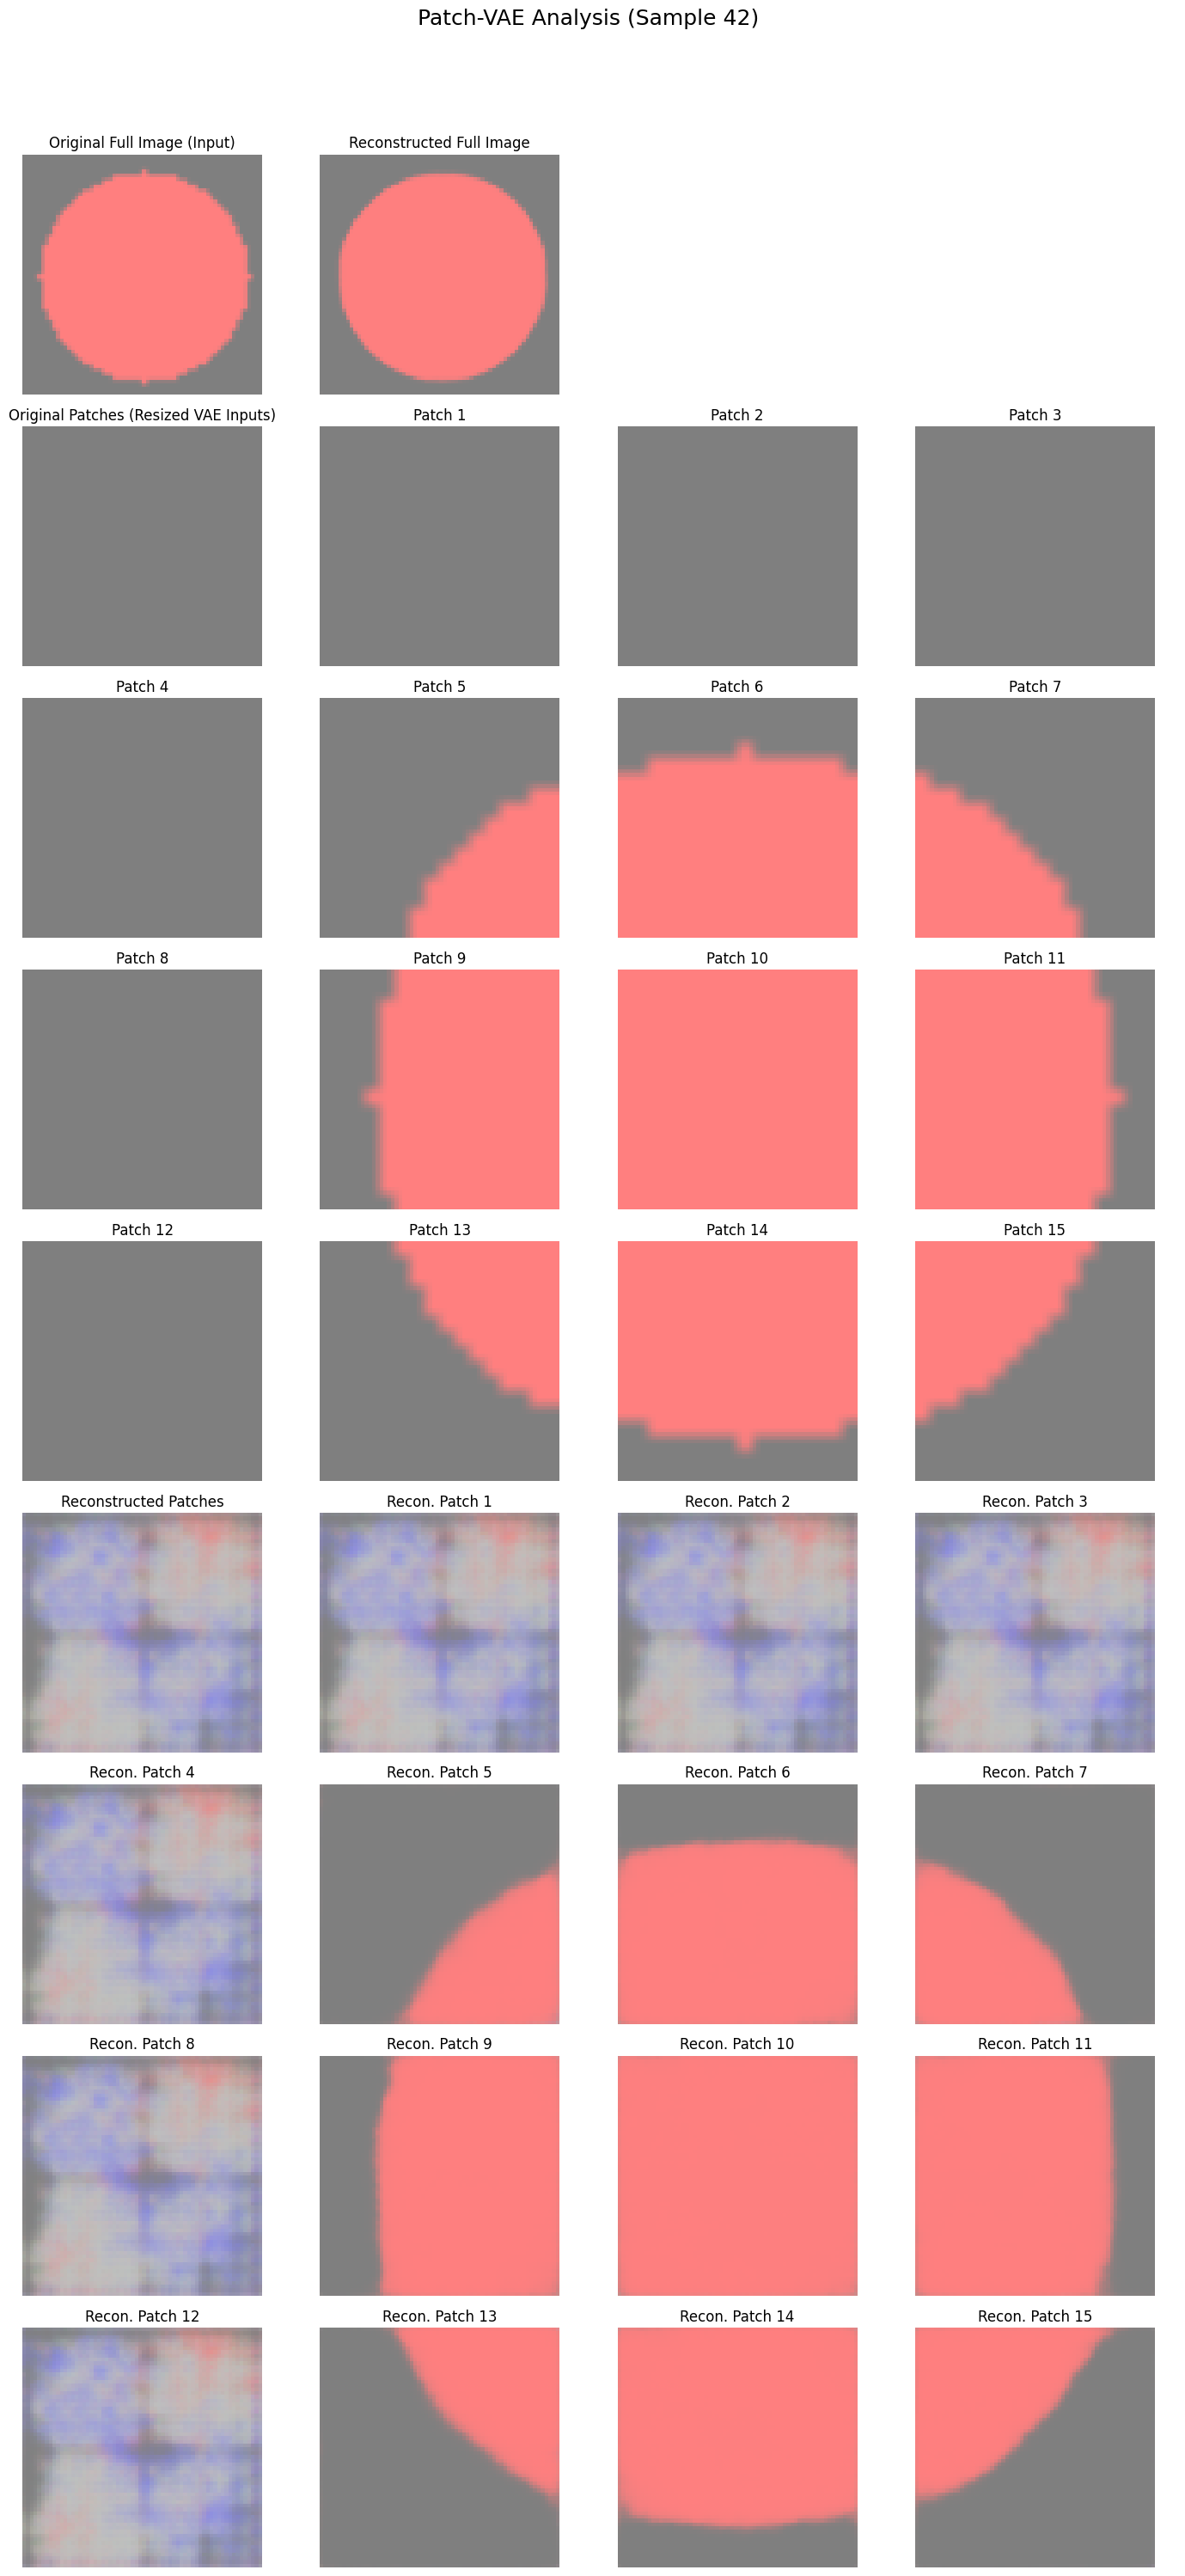

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Helper function to display images ---
def tensor_to_img(tensor):
    """
    Converts a (C, H, W) tensor to (H, W, C) numpy array 
    and denormalizes from [-1, 1] (from nn.Tanh) to [0, 1] for plotting.
    """
    # Detach from graph, move to CPU, change from (C,H,W) to (H,W,C)
    img = tensor.detach().cpu().permute(1, 2, 0).numpy()
    
    # Denormalize from [-1, 1] to [0, 1]
    img = (img * 0.5) + 0.5
    
    # Clip values to be safe
    return np.clip(img, 0, 1)

# --- 2. Get a single sample ---
# We assume 'dataset' is a dictionary containing 'train', 'val', etc.
# If 'val' doesn't exist, we'll try 'test' or just use 'dataset' itself.
# try:
#     val_dataset = dataset['val']
#     print("Using 'val' dataset.")
# except (KeyError, TypeError):
#     try:
#         val_dataset = dataset['test']
#         print("Using 'test' dataset.")
#     except (KeyError, TypeError):
#         print("Could not find 'val' or 'test' key, assuming `dataset` is the validation dataset itself.")
#         val_dataset = dataset

# Pick any sample you want to visualize
sample_idx = 42 
sample = dataset[sample_idx]

# --- 3. Prepare batch and move to device ---
device = model.device

# Create a batch of size 1 and move all tensors to the model's device
batch = {}
for k, v in sample.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.unsqueeze(0).to(device)
    else:
        batch[k] = v # Keep other non-tensor data

# --- 4. Forward pass ---
print(f"Running inference on sample {sample_idx}...")
with torch.no_grad(): # Disable gradient calculations
    outputs = model(batch)
print("Inference complete.")

# --- 5. Extract all necessary tensors ---
grid_h, grid_w = model.grid_size
num_patches = grid_h * grid_w

# 'outputs["images"]' contains the VAE's inputs (resized patches + full image)
# 'outputs["reconstructed_images"]' contains the VAE's outputs
all_vae_inputs = outputs["images"].squeeze(0).cpu()
all_reconstructions = outputs["reconstructed_images"].squeeze(0).cpu()

# The last item is the full image
original_full_image = all_vae_inputs[-1]
reconstructed_full_image = all_reconstructions[-1]

# The first 'num_patches' items are the (resized) patches
original_patches = all_vae_inputs[:-1] 
reconstructed_patches = all_reconstructions[:-1]

if original_patches.shape[0] != num_patches:
    print(f"Warning: Number of patches in output ({original_patches.shape[0]}) does not match grid size ({num_patches}). Check config.")

# --- 6. Visualization ---
print("Generating plot...")

# We need 1 row for full images, grid_h rows for orig patches, grid_h rows for recon patches
total_rows = 1 + 2 * grid_h
fig, axes = plt.subplots(total_rows, grid_w, figsize=(grid_w * 3.5, total_rows * 3.5))

# --- Handle edge cases for plt.subplots() return type ---
# This ensures 'axes' is always a 2D numpy array for consistent indexing
if total_rows == 1 and grid_w == 1:
    axes = np.array([[axes]]) # Single Axes object
elif total_rows == 1:
    axes = axes.reshape(1, -1) # 1D array (row)
elif grid_w == 1:
    axes = axes.reshape(-1, 1) # 1D array (column)
# 2D array case is default

fig.suptitle(f"Patch-VAE Analysis (Sample {sample_idx})", fontsize=18)

# --- Row 0: Full Images ---
axes[0, 0].imshow(tensor_to_img(original_full_image))
axes[0, 0].set_title("Original Full Image (Input)")
axes[0, 0].axis('off')

axes[0, 1].imshow(tensor_to_img(reconstructed_full_image))
axes[0, 1].set_title("Reconstructed Full Image")
axes[0, 1].axis('off')

# Hide other axes in the first row if grid_w > 2
for j in range(2, grid_w):
    axes[0, j].axis('off')

# --- Rows 1 to grid_h: Original Patches (Resized VAE Inputs) ---
for i in range(grid_h):
    for j in range(grid_w):
        patch_idx = i * grid_w + j
        if patch_idx >= len(original_patches): continue # Safety check
        
        ax = axes[1 + i, j]
        ax.imshow(tensor_to_img(original_patches[patch_idx]))
        ax.axis('off')
        
        # Add a section title to the first patch
        if i == 0 and j == 0:
            ax.set_title("Original Patches (Resized VAE Inputs)")
        else:
            ax.set_title(f"Patch {patch_idx}")
            
# --- Rows grid_h+1 to 2*grid_h: Reconstructed Patches ---
for i in range(grid_h):
    for j in range(grid_w):
        patch_idx = i * grid_w + j
        if patch_idx >= len(reconstructed_patches): continue # Safety check
            
        ax = axes[1 + grid_h + i, j]
        ax.imshow(tensor_to_img(reconstructed_patches[patch_idx]))
        ax.axis('off')

        # Add a section title to the first patch
        if i == 0 and j == 0:
            ax.set_title("Reconstructed Patches")
        else:
            ax.set_title(f"Recon. Patch {patch_idx}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

In [16]:
# --- Check for positive box volume ---
print("--- 📦 Box Volume Check ---")

# We use the 'outputs' dictionary from the previous cell
# Shapes are [1, num_patches + 1, embed_dim]
mu_min = outputs["mu_min"]
mu_max = outputs["mu_max"]

# Calculate the "side lengths" (delta) for all boxes
# We want this to be strictly positive
side_lengths = mu_max - mu_min

# Find all dimensions where mu_max <= mu_min
# These are "violations" or zero/negative volume dimensions
violations = side_lengths <= 0
num_violations = torch.sum(violations).item()
total_dims = side_lengths.numel()

if num_violations == 0:
    print("✅ Success! All dimensions have positive volume (mu_max > mu_min).")
else:
    print(f"🚨 Warning: Found {num_violations} / {total_dims} dimensions where mu_max <= mu_min.")

print("\n--- Stats on Box Side Lengths (mu_max - mu_min) ---")
print(f"  Min side length: {torch.min(side_lengths).item():.4f}")
print(f"  Max side length: {torch.max(side_lengths).item():.4f}")
print(f"  Mean side length: {torch.mean(side_lengths).item():.4f}")

# Optional: You can also print the indices of the first few violations
if num_violations > 0:
    print("\nFirst 5 violation indices (batch, box_idx, dim_idx):")
    violation_indices = torch.nonzero(violations, as_tuple=False)
    for i in range(min(5, num_violations)):
        print(f"  {violation_indices[i].cpu().numpy()}")

--- 📦 Box Volume Check ---
✅ Success! All dimensions have positive volume (mu_max > mu_min).

--- Stats on Box Side Lengths (mu_max - mu_min) ---
  Min side length: 1.1404
  Max side length: 39.7804
  Mean side length: 22.7675


In [17]:
batch = next(iter(dataloader))
for k, v in batch.items():
    print(k)
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(model.device)
    else:
        batch[k] = v

outputs = model(batch)

images
object_masks
metadata


In [18]:
def create_visualization_data(outputs, batch):

    mu_min = outputs['mu_min']
    mu_max = outputs['mu_max']

    num_batches = mu_min.shape[0]

    metadata = batch['metadata']
    colors = torch.stack(metadata['color']).permute(1, 0)

    visualization_data = []

    for batch_idx in range(num_batches):
        datapoint_box_data = []

        patch_mu_min = mu_min[batch_idx][:-1].detach().cpu().numpy()
        patch_mu_max = mu_max[batch_idx][:-1].detach().cpu().numpy()

        image_mu_min = mu_min[batch_idx][-1].unsqueeze(0).detach().cpu().numpy()
        image_mu_max = mu_max[batch_idx][-1].unsqueeze(0).detach().cpu().numpy()

        shape = metadata['shape'][batch_idx]
        color = colors[batch_idx]

        for patch_idx in range(len(patch_mu_min)):
            box_data = {
                'box_min': patch_mu_min[patch_idx],
                'box_max': patch_mu_max[patch_idx],
                'edge_color': color.tolist(),
                'face_color': [127, 127, 127],
                'corner_color': [0, 0, 0] if shape == "circle" else [255, 255, 255],
                'opacity': 'transparent',
            }
            datapoint_box_data.append(box_data)

        image_box_data = {
            'box_min': image_mu_min,
            'box_max': image_mu_max,
            'edge_color': color.tolist(),
            'face_color': [255, 255, 255],
            'corner_color': [0, 0, 0] if shape == "circle" else [255, 255, 255],
            'opacity': 'opaque'
        }
        datapoint_box_data.append(image_box_data)
        
        visualization_data.append(datapoint_box_data)

    return visualization_data

In [19]:
visualization_data = create_visualization_data(outputs, batch)

In [20]:
visualization_data

[[{'box_min': array([-8.251343 , -7.545811 , -7.5179734, -7.0748315, -7.6817894,
          -7.7673073, -7.2167535, -7.9488006, -7.584458 , -7.215548 ,
          -7.815119 , -7.3898396, -6.9115205, -7.449237 , -7.610446 ,
          -7.3961506], dtype=float32),
   'box_max': array([7.104864 , 7.013832 , 7.473363 , 7.151388 , 8.058807 , 8.986024 ,
          7.3653016, 7.4264555, 7.019564 , 9.052615 , 6.680672 , 8.049795 ,
          7.749381 , 7.7805405, 8.302944 , 7.4431524], dtype=float32),
   'edge_color': [0, 0, 255],
   'face_color': [127, 127, 127],
   'corner_color': [255, 255, 255],
   'opacity': 'transparent'},
  {'box_min': array([-8.251343 , -7.545811 , -7.5179734, -7.0748315, -7.6817894,
          -7.7673073, -7.2167535, -7.9488006, -7.584458 , -7.215548 ,
          -7.815119 , -7.3898396, -6.9115205, -7.449237 , -7.610446 ,
          -7.3961506], dtype=float32),
   'box_max': array([7.104864 , 7.013832 , 7.473363 , 7.151388 , 8.058807 , 8.986024 ,
          7.3653016, 7.426455

In [21]:
with open("/home/ubuntu/workspace/code/compositional-representation-learning/tmp/viz_data_exp_10.pkl", "wb") as f:
    pickle.dump(visualization_data, f)